# Import Libraries

In [ ]:
#Importing General Library
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno

#Sklearn Library
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, f1_score, recall_score, accuracy_score, precision_score
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing


#Keras Library
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


#NLTK Library
import tensorflow as tf
import nltk
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('omw-1.4')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score

#Import yellowbrick Library
#pip install -U yellowbrick ######
from yellowbrick.classifier import PrecisionRecallCurve

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Reading the Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DeGatto Project/EDA + Models/Womens Clothing E-Commerce Reviews.csv")

# Exploratory Data Analysis

In [ ]:
## Check the information in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In this dataset, we have 10 different columns and 23486 rows, some of the columns contain missing values, we will check if we need to fill them up or if we can delete them.

In this dataset, we will not use the following columns:


*   Unnamed: 0 as we have 23486 unique values
*   Clothing ID: In some cases we have multiple comments for the same apparel
*   Age: The age of the person who made the comment
*   Title: The title of the comment
*   Positive Feedback Count: How many positive feedback did the comment got
*   Division Name, Department Name and Class Name



The remaining columns:


*   Rating: 1 (Very Bad) to 5 (Very Good) will be removed later on in the code
*   Recommended IND: 1 (Recommended) / 0 (Not Recommended)
*   Review Text: Comment of the buyer / user



In [ ]:
df = df.drop(["Unnamed: 0", "Clothing ID","Age", "Title", "Positive Feedback Count", "Division Name", "Department Name", "Class Name"], axis = 1)
df.dropna(inplace = True)
## We removed the unnecessary columns and the na rows.

In [ ]:
df.info()
## As we can see, the only column that contains missing values is the Review Text
## It is the main column in our dataset, so we will drop the NA, as filling them
## is not possible, as this is textual data. Only 845 rows are removed from
## the 23486 rows which isn't much.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review Text      22641 non-null  object
 1   Rating           22641 non-null  int64 
 2   Recommended IND  22641 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 707.5+ KB


In our dataset, we have:

*   187 rows with Rating 4 or 5 and a negative Recommendation.
*   17261 rows with Rating 4 or 5 and a positive Recommendation.
*   109 rows with Rating 1 or 2 and a positive Recommendation.
*   2261 rows with Rating 1 or 2 and a negative Recommendation.
*   1170 rows with Rating 3 and a positive Recommendation
*   1653 rows with Rating 3 and a negative Recommendation



In [ ]:
def categorise(row):
    if row['Rating'] >= 4 and row['Recommended IND'] == 1:
        return 'Positive'
    elif row['Rating'] >= 4 and row['Recommended IND'] == 0:
        return 'Neutral'
    elif row['Rating'] == 3:
        return 'Neutral'
    elif row['Rating'] <= 2 and row['Recommended IND'] == 1:
        return 'Neutral'
    elif row['Rating'] <= 2 and row['Recommended IND'] == 0:
        return 'Negative'

df['Sentiment'] = df.apply(lambda row: categorise(row), axis = 1)

We created a new column, which is the Sentiment. This column will show, depending on the values of the rating and recommendation of the apparel product, if the sentiment is positive, neutral or negative.

Now we will check if the data is balanced or not.

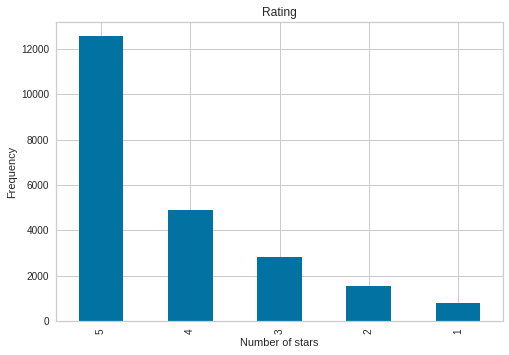

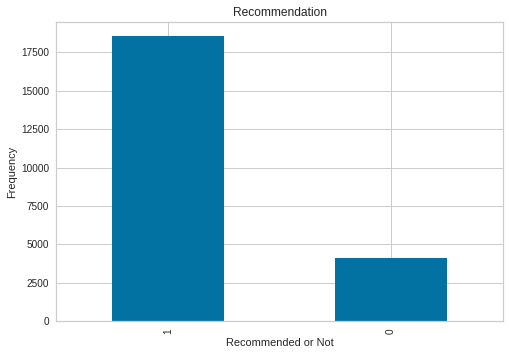

In [ ]:
df['Rating'].value_counts().plot.bar(title= 'Rating')
plt.xlabel('Number of stars')
plt.ylabel('Frequency')
plt.show()

df['Recommended IND'].value_counts().plot.bar(title= 'Recommendation')
plt.xlabel('Recommended or Not')
plt.ylabel('Frequency')
plt.show()

As we can clearly see, the data is not balanced at all.

Regarding the Rating, the rating frequency is going down from 5 to 1.

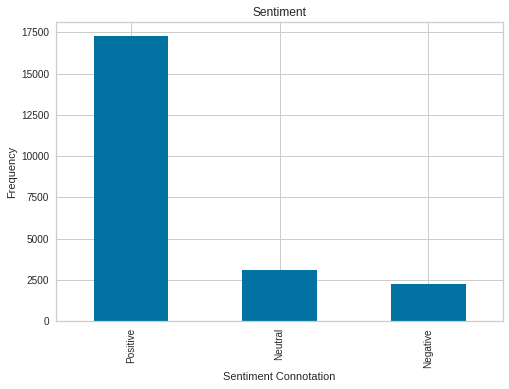

In [ ]:
df['Sentiment'].value_counts().plot.bar(title= 'Sentiment')
plt.xlabel('Sentiment Connotation')
plt.ylabel('Frequency')
plt.show()

From the above figure, we can see that the most recurrent sentiment is Positive.
Then, in second place we have Neutral sentiment, which has a higher frequency than Negative sentiment by not much.

In [ ]:
print("The Frequency of the sentiment connotation: \n", df['Sentiment'].value_counts(), sep = "")

The Frequency of the sentiment connotation: 
Positive    17261
Neutral      3119
Negative     2261
Name: Sentiment, dtype: int64


In [ ]:
df.describe()

,Rating,Recommended IND
count,22641.000000,22641.000000
mean,4.183561,0.818868
std,1.115762,0.385136
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [ ]:
df.describe(include = 'O')

,Review Text,Sentiment
count,22641,22641
unique,22634,3
top,Perfect fit and i've gotten so many compliment...,Positive
freq,3,17261


The table above shows that there are some Review Text that are mentionned more than once. The top sentence is "Perfect fit and i've gotten so many compliments, i buy all my suits from here now". The same comment was repeated 3 times, but it was given for different products as the Clothing ID assigned to it is different. But when checking the Age, we can see that the same age is repeated in all 3 cases, which can implies that the same person wrote it, and it might implicate the same shop. He's talking about bathing suits.

In [ ]:
## As now there is no more use for Rating and Recommended IND, we decided to remove them from our dataset.
df.drop(['Rating', 'Recommended IND'], axis = 1, inplace = True)

The remaining columns now are Sentiment and Review Text. We will build model to check how accurate it will be. We decided to develop the model and check if it will be to check for which specific part of the clothing are we commenting about. Is it about Size, Design, General, Longevity, Material and Comfort.

In [ ]:
df.head()

,Review Text,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,Positive
1,Love this dress! it's sooo pretty. i happene...,Positive
2,I had such high hopes for this dress and reall...,Neutral
3,"I love, love, love this jumpsuit. it's fun, fl...",Positive
4,This shirt is very flattering to all due to th...,Positive


# Data Pre-Processing / Cleaning / Text Mining

In [ ]:
reviews = df['Review Text'].str.strip()

NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')

def normalize_texts(texts):
    normalized_texts = []

    for text in texts:
        ## Lower Casing
        lower = str(text).lower()

        ## Removing Punctuations
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)

        ## Removing NON_ASCII values
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)

        ## Removing numbers
        no_num = re.sub('\W+','', no_non_ascii )

        ## appending to the list
        normalized_texts.append(no_non_ascii)

    return normalized_texts

df['Review Text'] = normalize_texts(df['Review Text'])

## Replacing the multiple whitespaces with just one
df["Review Text"] = df["Review Text"].replace(r'\s+', ' ', regex=True)

In [ ]:
df['Review Text']

0        absolutely wonderful silky and sexy and comfor...
1        love this dress it s sooo pretty i happened to...
2        i had such high hopes for this dress and reall...
3        i love love love this jumpsuit it s fun flirty...
4        this shirt is very flattering to all due to th...
                               ...                        
23481    i was very happy to snag this dress at such a ...
23482    it reminds me of maternity clothes soft stretc...
23483    this fit well but the top was very see through...
23484    i bought this dress for a wedding i have this ...
23485    this dress in a lovely platinum is feminine an...
Name: Review Text, Length: 22641, dtype: object

In [ ]:
## Counting the occurence of each word in our dataset
word_values = pd.Series(" ".join(df["Review Text"]).split()).value_counts()
#pd.DataFrame(word_values)
## Will we remove the stopwords, if yes which ones?
## Will we remove the rare words, and in that case why the ones with occurence <= 2

In [ ]:
pd.DataFrame(word_values)

,0
the,76166
i,67070
it,49284
and,49009
a,43117
...,...
admirable,1
slid,1
bizarrely,1
limitations,1


In [ ]:
list_stopwords = ["i", "you", "he", "she", "it", "we", "they", "me", "him", "her", "hers", "mine", "was", "were", "us", "them", "my", "your", "his", "her", "its", "our",
                  "their", "and", "whose", "an", "a", "the", "this", "to", "in", "on", "for", "of", "with", "so", "that", "be", "up", "at", "will", "has", "have", "lot",
                  "couple", "whatsoever", "sundry", "thou", "fewer", "thee", "ye", "hoo", "whomever", "about", "only", "from", "off"]

# Machine Learning

In [ ]:
x = df["Review Text"]
y = df["Sentiment"]

**Train-Test split**

**Logistic Regression**

In [ ]:
test_size = []

accuracy_test = []
accuracy_train = []

recall_train = []
recall_test = []

precision_train = []
precision_test = []

f1score_train = []
f1score_test = []

vector_method = []
c_value = []
max_iterations = []

vectorizer = CountVectorizer()
tf_idf_vectorizer = TfidfVectorizer()
over = RandomOverSampler(sampling_strategy = 'all', random_state = 45)

for i in range(2):
  for size in [0.1, 0.15, 0.2, 0.25, 0.3]:
    for c_rv in [0.5, 1.0, 1.5, 2.0]:
      for iterations_max in range(100, 1100, 100):
        test_size.append(size)
        max_iterations.append(iterations_max)
        c_value.append(c_rv)

        x = df["Review Text"]
        y = df["Sentiment"]

        encoding = preprocessing.LabelEncoder()
        y=encoding.fit_transform(y)

        if(i == 0):
          x = vectorizer.fit_transform(x)
          ## Stratify sampling is used in NLP to remove the bias
          x, y = over.fit_resample(x, y)
          x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = size, stratify = y, random_state = 42)

          vector_method.append("Count Vectorizer")

        else:
          x = tf_idf_vectorizer.fit_transform(x)
          x, y = over.fit_resample(x, y)
          x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = size, stratify = y, random_state = 42)

          vector_method.append("TF-IDF")

        log = LogisticRegression(C = c_rv, max_iter = iterations_max, class_weight= "balanced", l1_ratio = 0.1, random_state=42)
        log.fit(x_train,y_train)

        y_pred_test = log.predict(x_test)
        y_pred_train = log.predict(x_train)

        accuracy_test.append(accuracy_score(y_test, y_pred_test))
        accuracy_train.append(accuracy_score(y_train, y_pred_train))

        recall_train.append(recall_score(y_train, y_pred_train, average = 'weighted'))
        recall_test.append(recall_score(y_test, y_pred_test, average = 'weighted'))

        precision_train.append(precision_score(y_train, y_pred_train, average = 'weighted'))
        precision_test.append(precision_score(y_test, y_pred_test, average = 'weighted'))

        f1score_train.append(f1_score(y_train, y_pred_train, average = 'weighted'))
        f1score_test.append(f1_score(y_test, y_pred_test, average = 'weighted'))

dict = {'Vectorization Method': vector_method,  'Test Size': test_size, "C value": c_value, 'Max Iterations': max_iterations,
        'Accuracy Train':accuracy_train, 'Accuracy Test': accuracy_test, 'Precision Train': precision_train, 'Precision Test': precision_test,
        'Recall Train': recall_train, 'Recall Test': recall_test, 'F1 Score Train': f1score_train, 'F1 Score Test': f1score_test}
log_df = pd.DataFrame(dict)

In [ ]:
log_df

,Vectorization Method,Test Size,C value,Max Iterations,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Score Train,F1 Score Test
0,Count Vectorizer,0.1,0.5,100,0.874496,0.842248,0.874804,0.843059,0.874496,0.842248,0.874492,0.842450
1,Count Vectorizer,0.1,0.5,200,0.930242,0.897471,0.930684,0.898977,0.930242,0.897471,0.930245,0.897559
2,Count Vectorizer,0.1,0.5,300,0.944640,0.912338,0.944942,0.913724,0.944640,0.912338,0.944620,0.912303
3,Count Vectorizer,0.1,0.5,400,0.945670,0.913690,0.946016,0.915538,0.945670,0.913690,0.945662,0.913697
4,Count Vectorizer,0.1,0.5,500,0.946056,0.913111,0.946330,0.914693,0.946056,0.913111,0.946030,0.913070
...,...,...,...,...,...,...,...,...,...,...,...,...
395,TF-IDF,0.3,2.0,600,0.914037,0.875958,0.914680,0.877398,0.914037,0.875958,0.914063,0.876078
396,TF-IDF,0.3,2.0,700,0.914037,0.875958,0.914680,0.877398,0.914037,0.875958,0.914063,0.876078
397,TF-IDF,0.3,2.0,800,0.914037,0.875958,0.914680,0.877398,0.914037,0.875958,0.914063,0.876078
398,TF-IDF,0.3,2.0,900,0.914037,0.875958,0.914680,0.877398,0.914037,0.875958,0.914063,0.876078


In [ ]:
dict = {'Vectorization Method': vector_method,  'Test Size': test_size, "C value": c_value, 'Max Iterations': max_iterations,
        'Accuracy Train':accuracy_train, 'Accuracy Test': accuracy_test, 'Precision Train': precision_train, 'Precision Test': precision_test,
        'Recall Train': recall_train, 'Recall Test': recall_test, 'F1 Score Train': f1score_train, 'F1 Score Test': f1score_test}

log_df = pd.DataFrame(dict)

log_df

**Naive Bayes**

In [ ]:
test_size = []

accuracy_test = []
accuracy_train = []

recall_train = []
recall_test = []

precision_train = []
precision_test = []

f1score_train = []
f1score_test = []

vector_method = []
alpha_value = []

vectorizer = CountVectorizer()
tf_idf_vectorizer = TfidfVectorizer()
over = RandomOverSampler(sampling_strategy = 'all', random_state = 45)

for i in range(2):
  for size in [0.1, 0.15, 0.2,0.25,0.3]:
    for alp_ha in [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
      test_size.append(size)
      alpha_value.append(alp_ha)
      x = df["Review Text"]
      y = df["Sentiment"]

      encoding = preprocessing.LabelEncoder()
      y=encoding.fit_transform(y)

      if(i == 0):
        x = vectorizer.fit_transform(x)
        ## Stratify sampling is used in NLP to remove the bias
        x, y = over.fit_resample(x, y)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = size, stratify = y, random_state = 42)

        vector_method.append("Count Vectorizer")

      else:
        x = tf_idf_vectorizer.fit_transform(x)
        x, y = over.fit_resample(x, y)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = size, stratify = y, random_state = 42)

        vector_method.append("TF-IDF")

      cnb = MultinomialNB(alpha = alp_ha)
      cnb.fit(x_train, y_train)

      y_pred_test = cnb.predict(x_test)
      y_pred_train = cnb.predict(x_train)

      accuracy_test.append(accuracy_score(y_test, y_pred_test))
      accuracy_train.append(accuracy_score(y_train, y_pred_train))

      recall_train.append(recall_score(y_train, y_pred_train, average = 'weighted'))
      recall_test.append(recall_score(y_test, y_pred_test, average = 'weighted'))

      precision_train.append(precision_score(y_train, y_pred_train, average = 'weighted'))
      precision_test.append(precision_score(y_test, y_pred_test, average = 'weighted'))

      f1score_train.append(f1_score(y_train, y_pred_train, average = 'weighted'))
      f1score_test.append(f1_score(y_test, y_pred_test, average = 'weighted'))

dict = {'Vectorization Method': vector_method, 'Test Size': test_size, 'Alpha': alpha_value,
        'Accuracy Train':accuracy_train, 'Accuracy Test': accuracy_test, 'Precision Train': precision_train, 'Precision Test': precision_test,
        'Recall Train': recall_train, 'Recall Test': recall_test, 'F1 Score Train': f1score_train, 'F1 Score Test': f1score_test}
CNB_df = pd.DataFrame(dict)

**SVM**

In [ ]:
test_size = []

accuracy_test = []
accuracy_train = []

recall_train = []
recall_test = []

precision_train = []
precision_test = []

f1score_train = []
f1score_test = []

c_value = []
vector_method = []

vectorizer = CountVectorizer()
tf_idf_vectorizer = TfidfVectorizer()
over = RandomOverSampler(sampling_strategy = 'all', random_state = 45)

for i in range(2):
  for size in [0.1, 0.15, 0.2,0.25,0.3]:
    for c_rv in [0.3, 0.6, 0.9, 1.2, 1.5, 1.8]:

        test_size.append(size)
        c_value.append(c_rv)

        x = df["Review Text"]
        y = df["Sentiment"]

        encoding = preprocessing.LabelEncoder()
        y=encoding.fit_transform(y)

        if(i == 0):
          x = vectorizer.fit_transform(x)
          ## Stratify sampling is used in NLP to remove the bias
          x, y = over.fit_resample(x, y)
          x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = size, stratify = y, random_state = 42)

          vector_method.append("Count Vectorizer")

        else:
          x = tf_idf_vectorizer.fit_transform(x)
          x, y = over.fit_resample(x, y)
          x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = size, stratify = y, random_state = 42)

          vector_method.append("TF-IDF")

        svc = LinearSVC(C=c_rv, class_weight="balanced", random_state=101)
        svc.fit(x_train,y_train)

        y_pred_test = svc.predict(x_test)
        y_pred_train = svc.predict(x_train)

        accuracy_test.append(accuracy_score(y_test, y_pred_test))
        accuracy_train.append(accuracy_score(y_train, y_pred_train))

        recall_train.append(recall_score(y_train, y_pred_train, average = 'weighted'))
        recall_test.append(recall_score(y_test, y_pred_test, average = 'weighted'))

        precision_train.append(precision_score(y_train, y_pred_train, average = 'weighted'))
        precision_test.append(precision_score(y_test, y_pred_test, average = 'weighted'))

        f1score_train.append(f1_score(y_train, y_pred_train, average = 'weighted'))
        f1score_test.append(f1_score(y_test, y_pred_test, average = 'weighted'))

dict = {'Vectorization Method': vector_method, 'Test Size': test_size, 'C Value': c_rv,
        'Accuracy Train':accuracy_train, 'Accuracy Test': accuracy_test, 'Precision Train': precision_train, 'Precision Test': precision_test,
        'Recall Train': recall_train, 'Recall Test': recall_test, 'F1 Score Train': f1score_train, 'F1 Score Test': f1score_test}
svm_df = pd.DataFrame(dict)

In [ ]:
svm_df

,Vectorization Method,Test Size,C Value,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Score Train,F1 Score Test
0,Count Vectorizer,0.10,1.8,0.962686,0.929523,0.962667,0.930610,0.962686,0.929523,0.962633,0.929170
1,Count Vectorizer,0.10,1.8,0.972170,0.936088,0.972151,0.937306,0.972170,0.936088,0.972133,0.935701
2,Count Vectorizer,0.10,1.8,0.976654,0.938984,0.976631,0.940242,0.976654,0.938984,0.976624,0.938517
3,Count Vectorizer,0.10,1.8,0.978972,0.940529,0.978950,0.941951,0.978972,0.940529,0.978948,0.940045
4,Count Vectorizer,0.10,1.8,0.980667,0.941688,0.980648,0.943214,0.980667,0.941688,0.980647,0.941196
5,Count Vectorizer,0.10,1.8,0.981611,0.943618,0.981592,0.945154,0.981611,0.943618,0.981593,0.943146
6,Count Vectorizer,0.15,1.8,0.962785,0.930484,0.962772,0.931458,0.962785,0.930484,0.962733,0.930205
7,Count Vectorizer,0.15,1.8,0.972986,0.938465,0.972968,0.939514,0.972986,0.938465,0.972946,0.938109
8,Count Vectorizer,0.15,1.8,0.976826,0.939367,0.976805,0.940584,0.976826,0.939367,0.976793,0.938942
9,Count Vectorizer,0.15,1.8,0.979121,0.940783,0.979100,0.942120,0.979121,0.940783,0.979096,0.940321


# Deep Learning

**LSTM with Count Vectorizer**

In [ ]:
vectorizer = CountVectorizer()
tf_idf_vectorizer = TfidfVectorizer()
over = RandomOverSampler(sampling_strategy = 'all', random_state = 45)

In [ ]:
df.sort_index()
x = df["Review Text"]
y = df["Sentiment"]

encoding = preprocessing.LabelEncoder()
y=encoding.fit_transform(y)
x = vectorizer.fit_transform(x)
## Stratify sampling is used in NLP to remove the bias
x, y = over.fit_resample(x, y)

#x=np.array(x)
#y=np.array(y)

In [ ]:
x

<51783x13666 sparse matrix of type '<class 'numpy.float64'>'
	with 2237811 stored elements in Compressed Sparse Row format>

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 42)

In [ ]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, batch_size = 64)

InvalidArgumentError: ignored

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 2, 128)            67072     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 2, 128)            131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 2, 128)            0         
                                                                 
 dropout_2 (Dropout)         (None, 2, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)               

**Saving in Excel File**

In [ ]:
!pip install xlsxwriter
with pd.ExcelWriter('/content/drive/MyDrive/DeGatto Project/EDA + Models/Sentiment Output.xlsx', engine='xlsxwriter') as writer:
    log_df.to_excel(writer, sheet_name='Logistic Regression')
    CNB_df.to_excel(writer, sheet_name='Multinomial Naive Bayes')
    svm_df.to_excel(writer, sheet_name='SVM')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
